# Import Packages for Actor-Critic

In [1]:
import gymnasium as gym

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical

from tqdm import tqdm
import matplotlib.pyplot as plt

# We'll use OmegaConf to manage hyperparameters!

In [2]:
#!pip install omegaconf

In [3]:
from omegaconf import OmegaConf

# Environment
- CartPole-v1

In [4]:
env = gym.make('CartPole-v1')
env

<TimeLimit<OrderEnforcing<PassiveEnvChecker<CartPoleEnv<CartPole-v1>>>>>

# Hyperparameters

In [5]:
AC_config = OmegaConf.create({
    # DQN parameters
    'gamma': 0.99,
    
    # policy network parameters
    'device': 'cpu',
    'hidden_dim': 64,
    'state_dim': env.observation_space.shape[0],
    'action_dim': int(env.action_space.n),

    # learning parameters
    'learning_rate': 0.0001,
    'n_rollout': 10,
})

In [6]:
class ActorCritic(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.data = []
        self.config = config
        
        # actor network
        self.actor = ...
        
        # critic network
        self.critic = ...
        
        # load them to gpu (if available)
        self.to(self.config.device)
        
        # optimizer
        self.optimizer = torch.optim.Adam(self.parameters(), lr=self.config.learning_rate)
    
    # add transition data
    def put_data(self, transition):
        self.data.append(transition)
        
    # convert transitions to batch data
    def make_batch(self):
        state_list, action_list, reward_list, next_state_list, terminated_list = [], [], [], [], []
        for transition in self.data:
            state, action, reward, next_state, termindated = transition
            
            state_list.append(list(state))
            action_list.append([action])
            reward_list.append([reward / 100.0])
            next_state_list.append(list(next_state))
            termindated_mask = 0.0 if termindated else 1.0
            terminated_list.append([termindated_mask])
        
        state_batch = torch.tensor(state_list, dtype=torch.float)
        action_batch = torch.tensor(action_list)
        reward_batch = torch.tensor(reward_list, dtype=torch.float)
        next_state_batch = torch.tensor(next_state_list, dtype=torch.float)
        terminated_batch = torch.tensor(terminated_list, dtype=torch.float)
        
        # clear buffer
        self.data = []
        
        return state_batch, action_batch, reward_batch, next_state_batch, terminated_batch
  
    def update(self):
        # get data using self.make_batch()
        states, actions, rewards, next_states, terminated = self.make_batch()
        
        # compute TD target
        td_target = ...
        
        # compute TD error
        td_error = ...
        
        # computer Actor loss
        all_action_probs = self.actor(states)
        action_probs = all_action_probs.gather(1, actions)
        Actor_loss = ...
        
        # compute Critic loss
        Critic_loss = ...
        
        # Aggregate
        loss = ...
        
        # backpropagation
        self.optimizer.zero_grad()
        loss.mean().backward()
        self.optimizer.step()

In [7]:
num_epis, epi_rews = 10000, []
agent = ActorCritic(AC_config)

for n_epi in tqdm(range(num_epis)):
    state, _ = env.reset()
    terminated, truncated = False, False
    epi_rew = 0
    
    while not (terminated or truncated):
        for t in range(AC_config.n_rollout):
            # get action probs from actor & sample -- use Categorical!
            ...
            
            # step
            next_state, reward, terminated, truncated, _ = env.step(action)
            
            # collect transition
            agent.put_data(...)
            
            # state transition
            state = next_state
            
            # record reward
            epi_rew += reward
            
            if terminated or truncated:
                break
            
    # update
    agent.update()
    
    # record
    epi_rews += [epi_rew]
    
env.close()

100%|██████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [06:40<00:00, 24.97it/s]


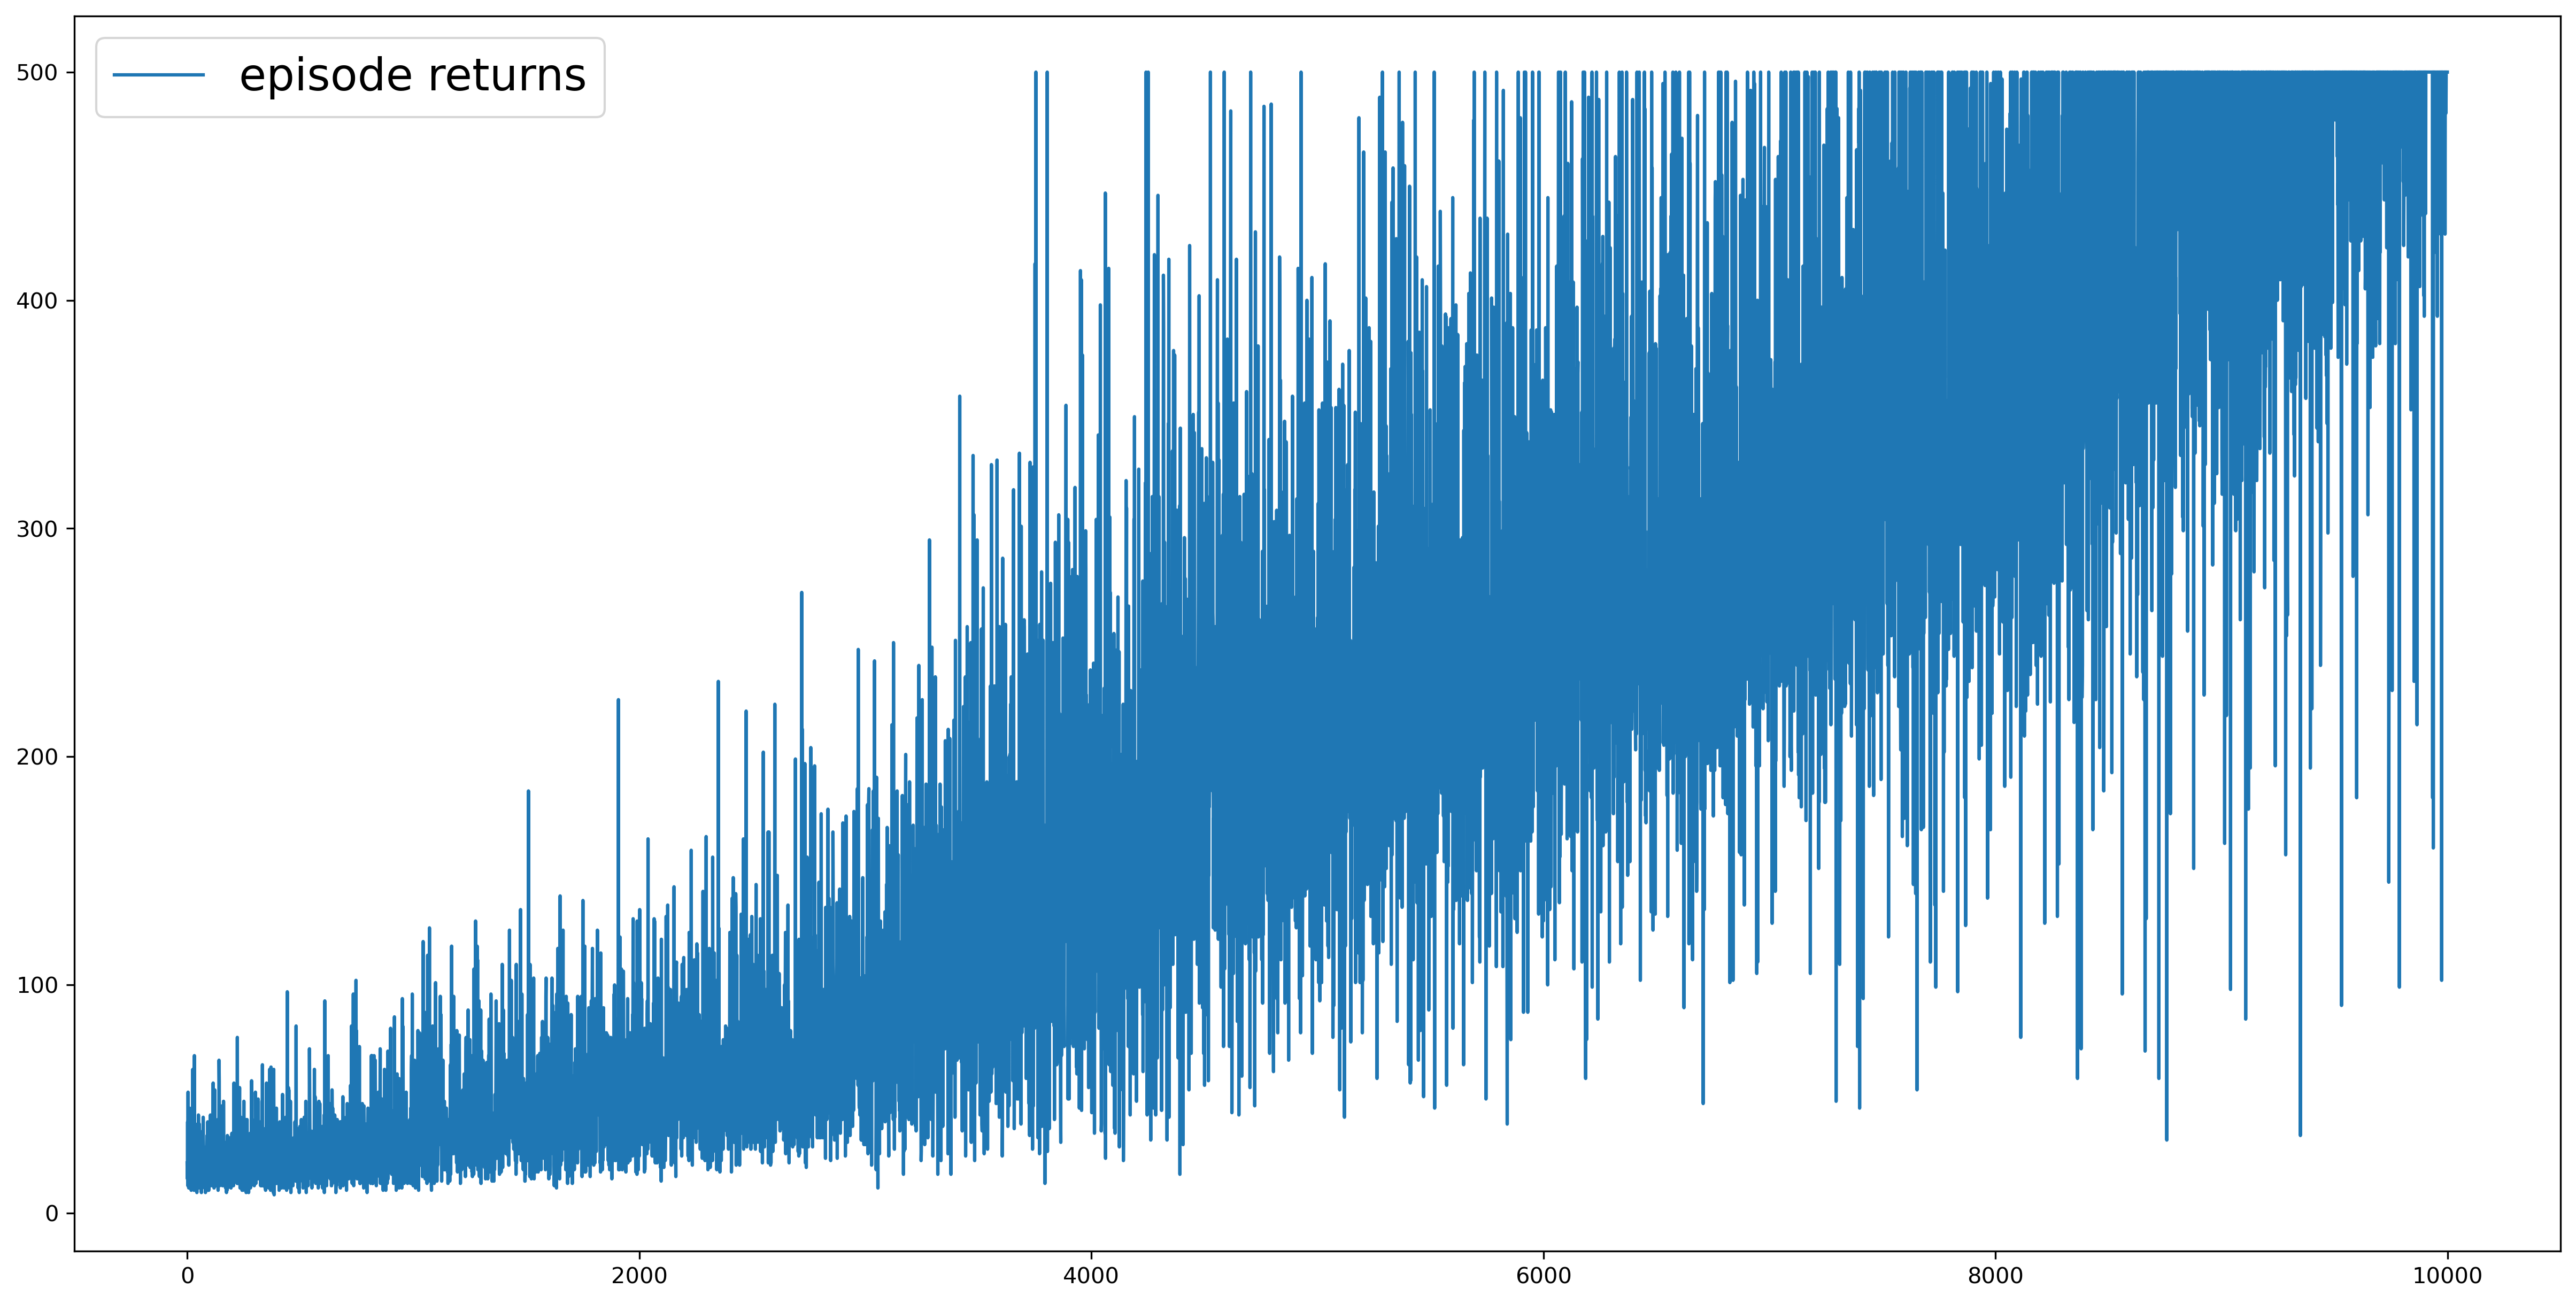

In [8]:
plt.figure(figsize=(20, 10), dpi=300)
plt.plot(epi_rews, label='episode returns')
plt.legend(fontsize=20)
plt.show()
plt.close()